#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 1331
- Negative: 18848
- Verhältnis: 14.160781367392937


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

id                   0
label                0
tweet                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           15873
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [12]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [13]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [14]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [15]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [16]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [17]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [18]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [20]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [22]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [23]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [24]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [25]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [26]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [27]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 95.14%
------------------------------------------------
Confusion Matrix:
      0   1
0  5662  25
1   269  98
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.80      0.27      0.40       367

    accuracy                           0.95      6054
   macro avg       0.88      0.63      0.69      6054
weighted avg       0.95      0.95      0.94      6054



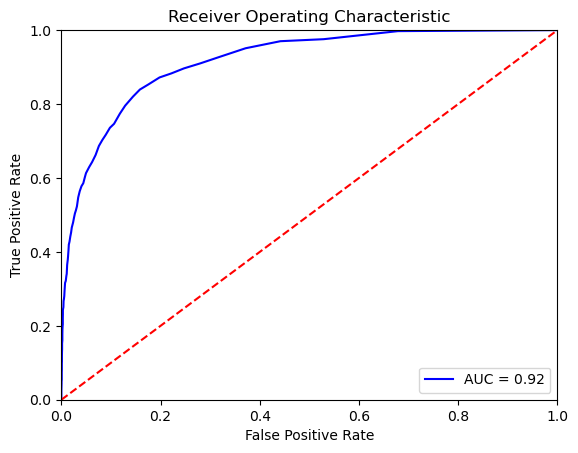

In [28]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 94.70%
------------------------------------------------
Confusion Matrix:
      0   1
0  5659  28
1   293  74
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.73      0.20      0.32       367

    accuracy                           0.95      6054
   macro avg       0.84      0.60      0.64      6054
weighted avg       0.94      0.95      0.93      6054



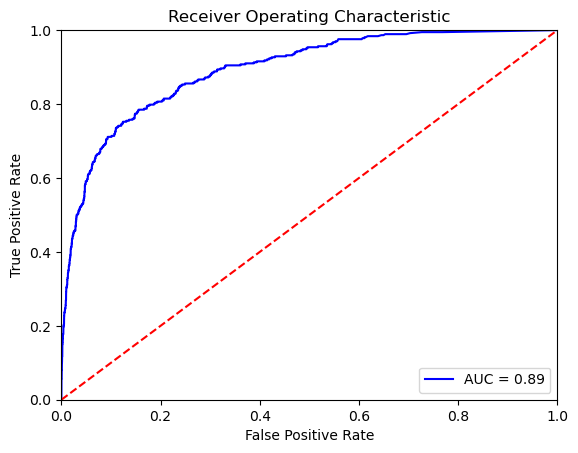

In [29]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.13%
------------------------------------------------
Confusion Matrix:
      0   1
0  5661  26
1   269  98
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.79      0.27      0.40       367

    accuracy                           0.95      6054
   macro avg       0.87      0.63      0.69      6054
weighted avg       0.94      0.95      0.94      6054



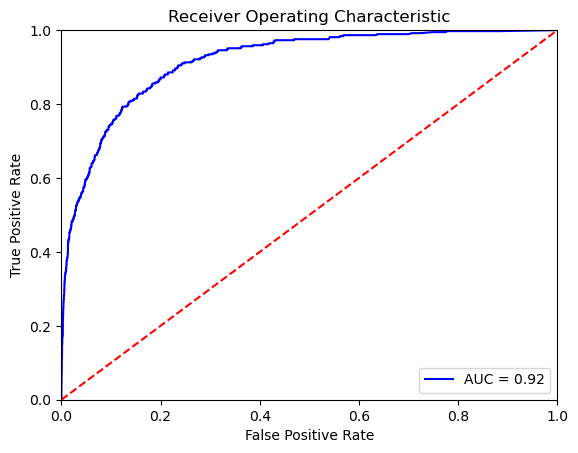

In [30]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 85.58%
------------------------------------------------
Confusion Matrix:
      0    1
0  4871  816
1    57  310
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5687
           1       0.28      0.84      0.42       367

    accuracy                           0.86      6054
   macro avg       0.63      0.85      0.67      6054
weighted avg       0.95      0.86      0.89      6054



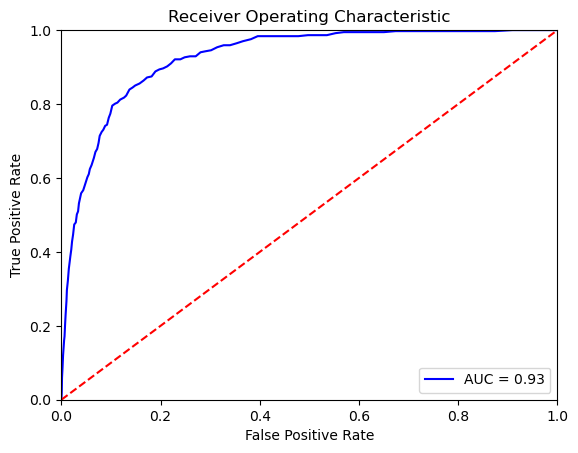

In [31]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 95.33%
------------------------------------------------
Confusion Matrix:
      0    1
0  5620   67
1   216  151
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.69      0.41      0.52       367

    accuracy                           0.95      6054
   macro avg       0.83      0.70      0.75      6054
weighted avg       0.95      0.95      0.95      6054



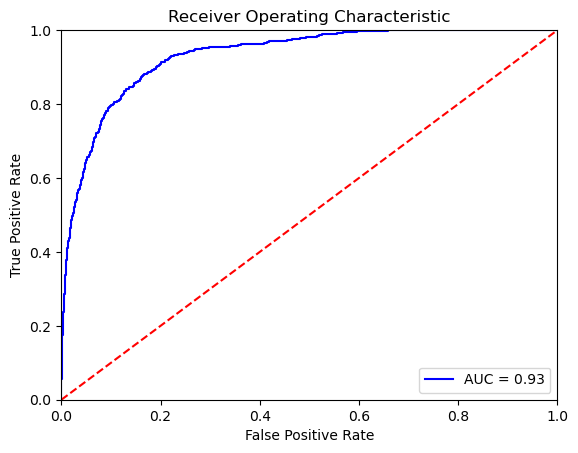

In [32]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  5629   58
1   222  145
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.71      0.40      0.51       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



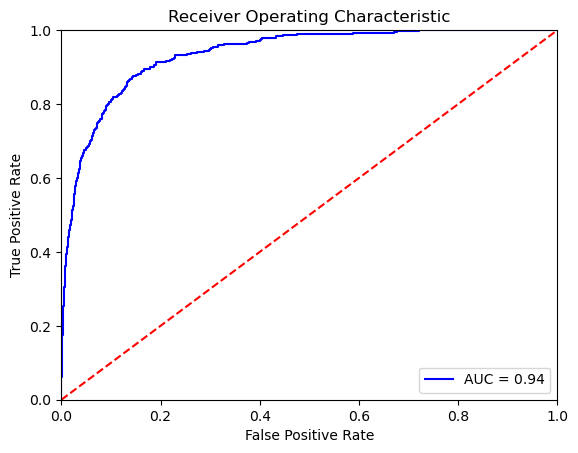

In [33]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.31%
------------------------------------------------
Confusion Matrix:
      0    1
0  5623   64
1   220  147
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.70      0.40      0.51       367

    accuracy                           0.95      6054
   macro avg       0.83      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



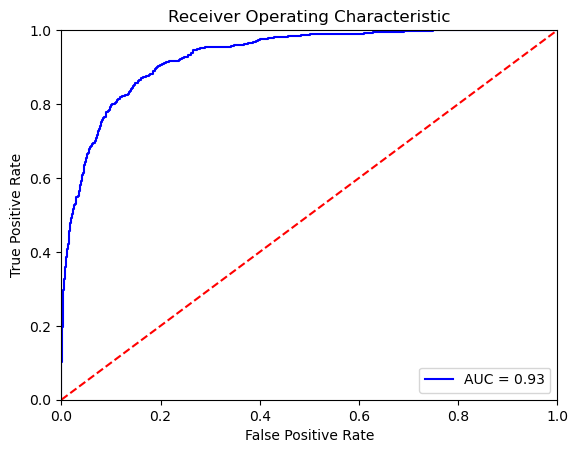

In [34]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 95.06%
------------------------------------------------
Confusion Matrix:
      0    1
0  5612   75
1   224  143
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.66      0.39      0.49       367

    accuracy                           0.95      6054
   macro avg       0.81      0.69      0.73      6054
weighted avg       0.94      0.95      0.94      6054



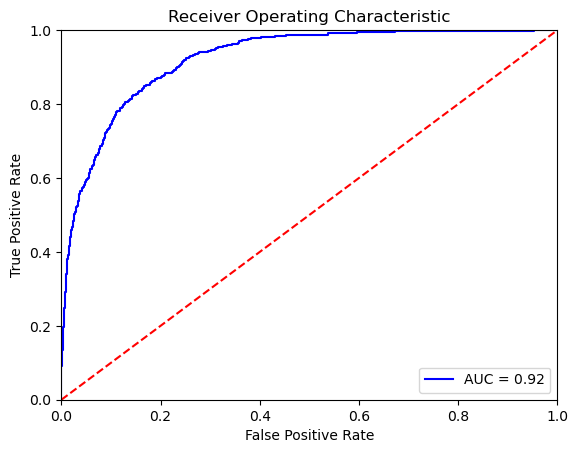

In [35]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.5524522	total: 217ms	remaining: 21.5s
1:	learn: 0.4449268	total: 298ms	remaining: 14.6s
2:	learn: 0.3684320	total: 385ms	remaining: 12.5s
3:	learn: 0.3147716	total: 477ms	remaining: 11.4s
4:	learn: 0.2813433	total: 516ms	remaining: 9.8s
5:	learn: 0.2570302	total: 554ms	remaining: 8.68s
6:	learn: 0.2355186	total: 593ms	remaining: 7.88s
7:	learn: 0.2206811	total: 628ms	remaining: 7.23s
8:	learn: 0.2085572	total: 675ms	remaining: 6.83s
9:	learn: 0.1997085	total: 732ms	remaining: 6.58s
10:	learn: 0.1919891	total: 809ms	remaining: 6.55s
11:	learn: 0.1861023	total: 874ms	remaining: 6.41s
12:	learn: 0.1811263	total: 920ms	remaining: 6.16s
13:	learn: 0.1757954	total: 962ms	remaining: 5.91s
14:	learn: 0.1723515	total: 1.01s	remaining: 5.74s
15:	learn: 0.1685901	total: 1.06s	remaining: 5.58s
16:	learn: 0.1660172	total: 1.12s	remaining: 5.47s
17:	learn: 0.1642204	total: 1.21s	remaining: 5.5s
18:	learn: 0.1620266	total: 1.29s	remaining: 5.51s
19:	learn: 0.1600943	total: 1.34s	remaining

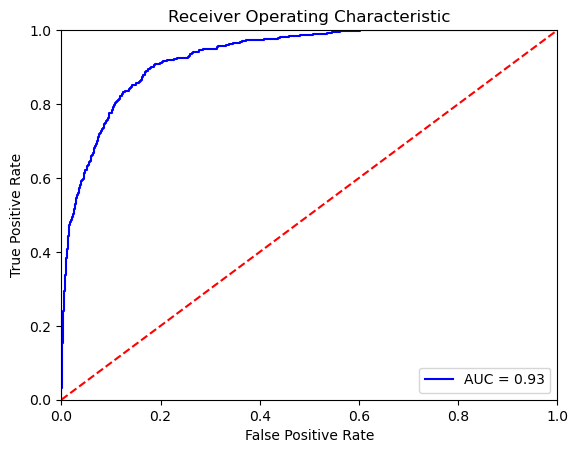

In [36]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 964, number of negative: 13160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 14124, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068253 -> initscore=-2.613846
[LightGBM] [Info] Start training from score -2.613846
model accuracy for classification is = 95.26%
------------------------------------------------
Confusion Matrix:
      0    1
0  5630   57
1   230  137
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.71      0.37      0.49       367

    accuracy                           0.95      6054
   macro avg       0.83      0.68      0.73      6054
weighted a

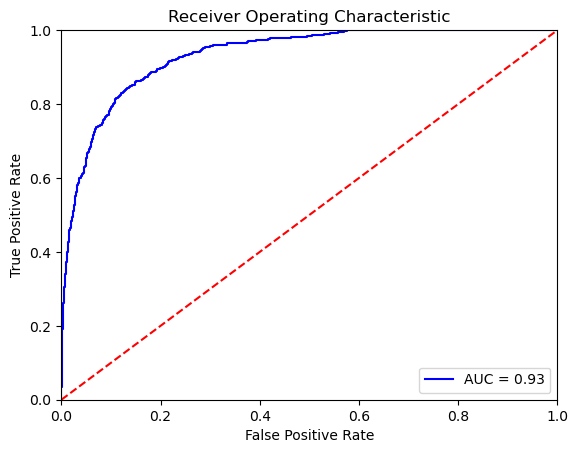

In [37]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.09%
------------------------------------------------
Confusion Matrix:
      0    1
0  5620   67
1   230  137
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.67      0.37      0.48       367

    accuracy                           0.95      6054
   macro avg       0.82      0.68      0.73      6054
weighted avg       0.94      0.95      0.94      6054



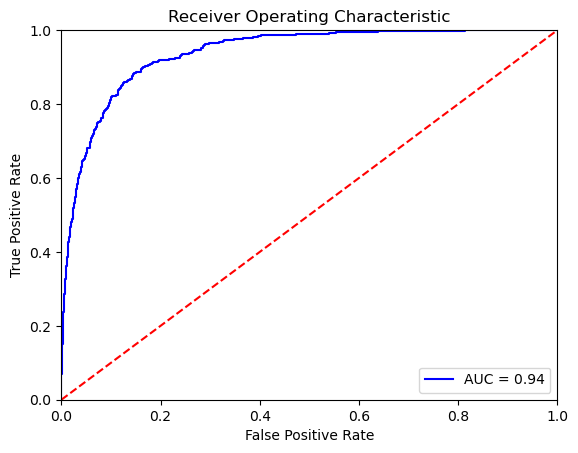

In [38]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [39]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 96.13%
------------------------------------------------
Confusion Matrix:
      0    1
0  5656   31
1   203  164
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5687
           1       0.84      0.45      0.58       367

    accuracy                           0.96      6054
   macro avg       0.90      0.72      0.78      6054
weighted avg       0.96      0.96      0.96      6054



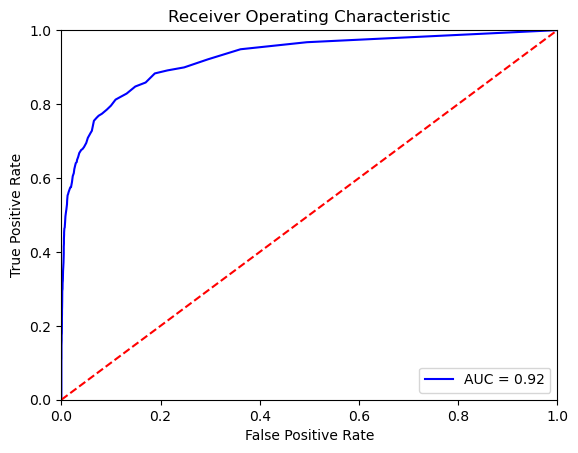

In [40]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.04%
------------------------------------------------
Confusion Matrix:
      0    1
0  5649   38
1   262  105
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.73      0.29      0.41       367

    accuracy                           0.95      6054
   macro avg       0.84      0.64      0.69      6054
weighted avg       0.94      0.95      0.94      6054



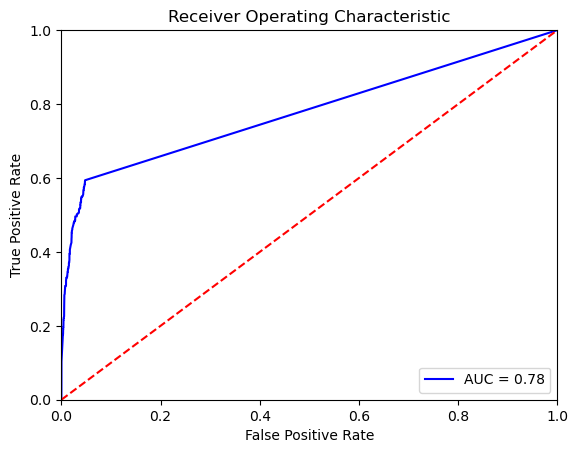

In [41]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.71%
------------------------------------------------
Confusion Matrix:
      0   1
0  5686   1
1   319  48
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.98      0.13      0.23       367

    accuracy                           0.95      6054
   macro avg       0.96      0.57      0.60      6054
weighted avg       0.95      0.95      0.93      6054



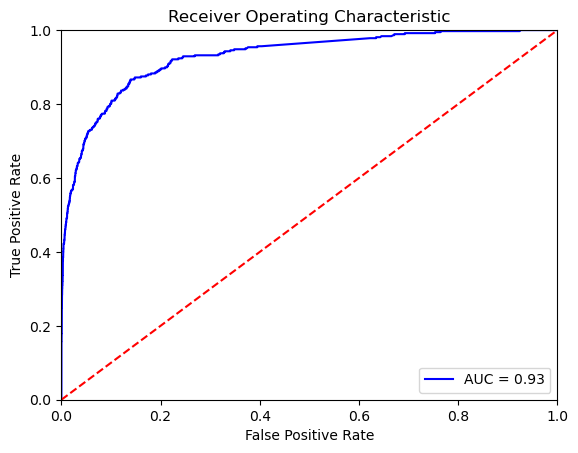

In [42]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 81.60%
------------------------------------------------
Confusion Matrix:
      0     1
0  4619  1068
1    46   321
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      5687
           1       0.23      0.87      0.37       367

    accuracy                           0.82      6054
   macro avg       0.61      0.84      0.63      6054
weighted avg       0.94      0.82      0.86      6054



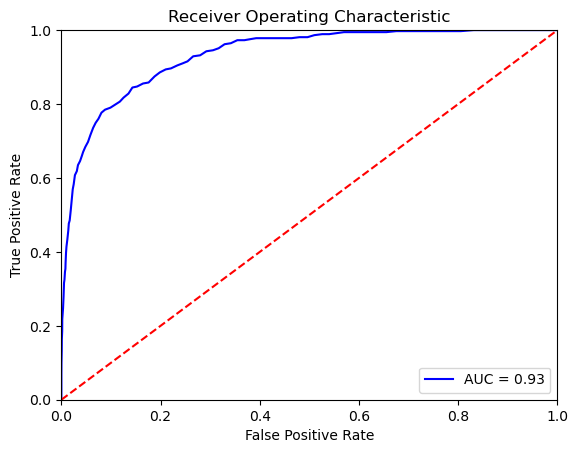

In [43]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.67%
------------------------------------------------
Confusion Matrix:
      0    1
0  5651   36
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.80      0.38      0.52       367

    accuracy                           0.96      6054
   macro avg       0.88      0.69      0.75      6054
weighted avg       0.95      0.96      0.95      6054



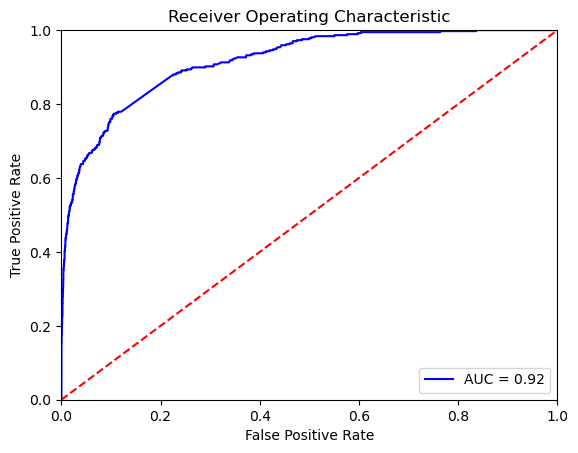

In [44]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  5639   48
1   217  150
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.76      0.41      0.53       367

    accuracy                           0.96      6054
   macro avg       0.86      0.70      0.75      6054
weighted avg       0.95      0.96      0.95      6054



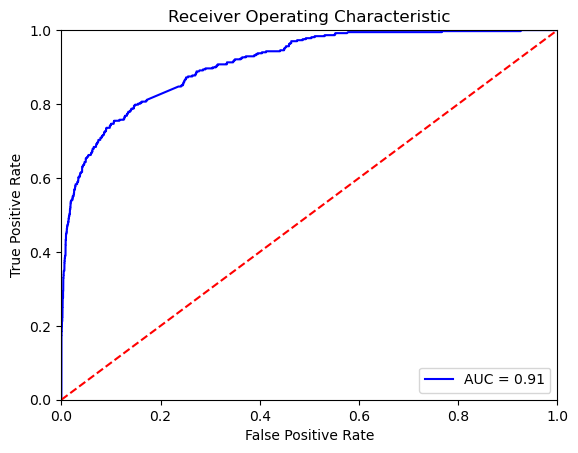

In [45]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.33%
------------------------------------------------
Confusion Matrix:
      0    1
0  5642   45
1   238  129
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.74      0.35      0.48       367

    accuracy                           0.95      6054
   macro avg       0.85      0.67      0.73      6054
weighted avg       0.95      0.95      0.95      6054



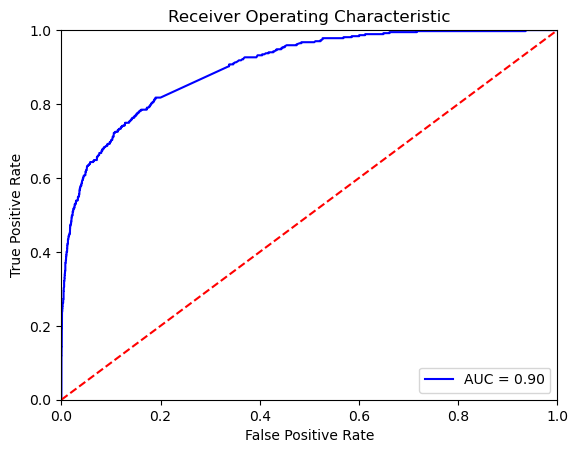

In [46]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 95.42%
------------------------------------------------
Confusion Matrix:
      0    1
0  5633   54
1   223  144
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.73      0.39      0.51       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



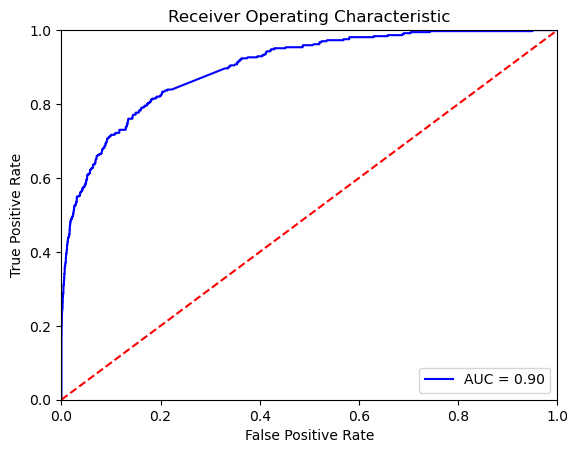

In [47]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.5878504	total: 64ms	remaining: 6.33s
1:	learn: 0.5083806	total: 140ms	remaining: 6.86s
2:	learn: 0.4472012	total: 204ms	remaining: 6.59s
3:	learn: 0.3980520	total: 270ms	remaining: 6.47s
4:	learn: 0.3589142	total: 334ms	remaining: 6.34s
5:	learn: 0.3289160	total: 409ms	remaining: 6.41s
6:	learn: 0.3033367	total: 478ms	remaining: 6.35s
7:	learn: 0.2818252	total: 560ms	remaining: 6.44s
8:	learn: 0.2685399	total: 626ms	remaining: 6.33s
9:	learn: 0.2572590	total: 697ms	remaining: 6.27s
10:	learn: 0.2478268	total: 766ms	remaining: 6.2s
11:	learn: 0.2397083	total: 832ms	remaining: 6.1s
12:	learn: 0.2329392	total: 898ms	remaining: 6.01s
13:	learn: 0.2277790	total: 964ms	remaining: 5.92s
14:	learn: 0.2235385	total: 1.03s	remaining: 5.84s
15:	learn: 0.2198037	total: 1.09s	remaining: 5.75s
16:	learn: 0.2165632	total: 1.16s	remaining: 5.66s
17:	learn: 0.2138707	total: 1.22s	remaining: 5.58s
18:	learn: 0.2117195	total: 1.29s	remaining: 5.52s
19:	learn: 0.2096245	total: 1.37s	remaining:

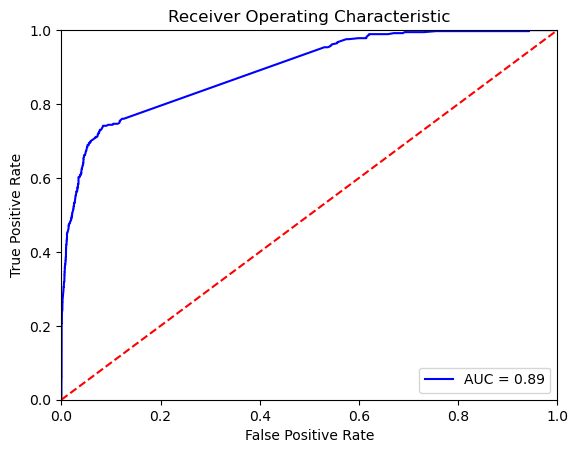

In [48]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 964, number of negative: 13160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28759
[LightGBM] [Info] Number of data points in the train set: 14124, number of used features: 1080
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068253 -> initscore=-2.613846
[LightGBM] [Info] Start training from score -2.613846
model accuracy for classification is = 95.44%
------------------------------------------------
Confusion Matrix:
      0    1
0  5632   55
1   221  146
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.73      0.40      0.51       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.75      6054
weighted 

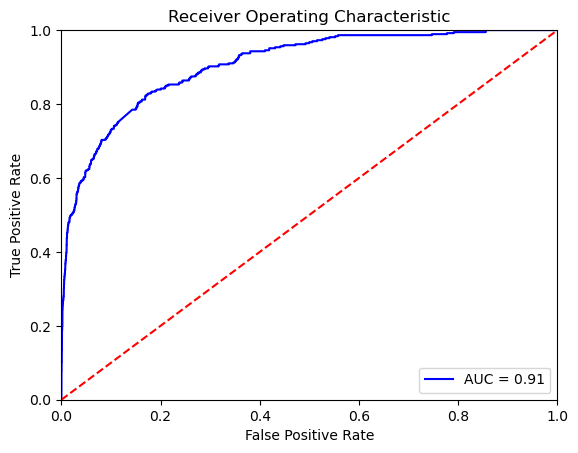

In [49]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 96.05%
------------------------------------------------
Confusion Matrix:
      0    1
0  5604   83
1   156  211
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5687
           1       0.72      0.57      0.64       367

    accuracy                           0.96      6054
   macro avg       0.85      0.78      0.81      6054
weighted avg       0.96      0.96      0.96      6054



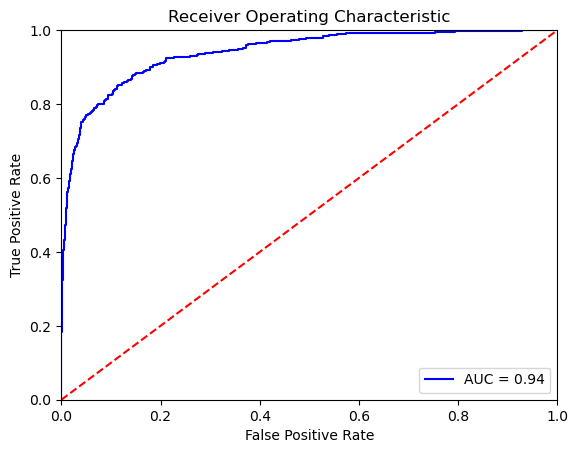

In [50]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [51]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 94.68%
------------------------------------------------
Confusion Matrix:
      0   1
0  5676  11
1   311  56
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.84      0.15      0.26       367

    accuracy                           0.95      6054
   macro avg       0.89      0.58      0.62      6054
weighted avg       0.94      0.95      0.93      6054



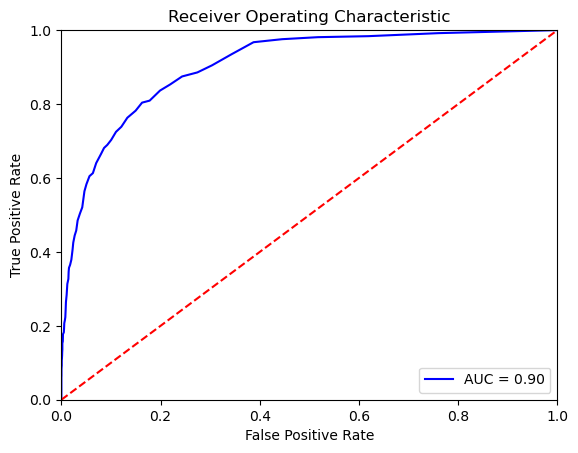

In [52]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.47%
------------------------------------------------
Confusion Matrix:
      0   1
0  5671  16
1   319  48
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.75      0.13      0.22       367

    accuracy                           0.94      6054
   macro avg       0.85      0.56      0.60      6054
weighted avg       0.93      0.94      0.93      6054



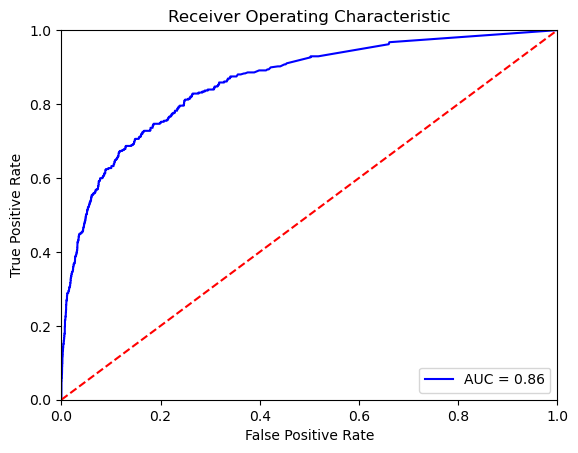

In [53]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.62%
------------------------------------------------
Confusion Matrix:
      0   1
0  5675  12
1   314  53
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.82      0.14      0.25       367

    accuracy                           0.95      6054
   macro avg       0.88      0.57      0.61      6054
weighted avg       0.94      0.95      0.93      6054



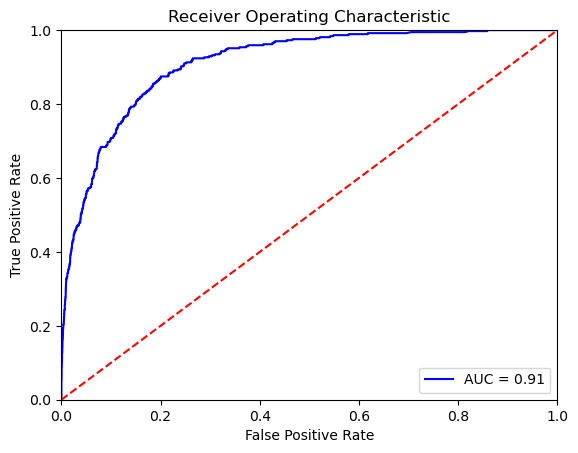

In [54]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 85.15%
------------------------------------------------
Confusion Matrix:
      0    1
0  4843  844
1    55  312
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      5687
           1       0.27      0.85      0.41       367

    accuracy                           0.85      6054
   macro avg       0.63      0.85      0.66      6054
weighted avg       0.95      0.85      0.88      6054



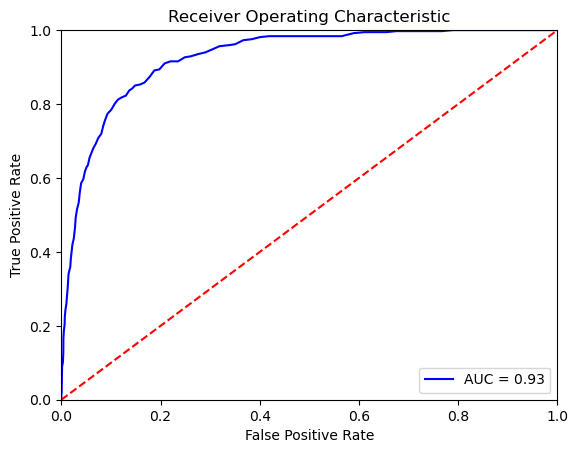

In [55]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 95.31%
------------------------------------------------
Confusion Matrix:
      0    1
0  5624   63
1   221  146
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.70      0.40      0.51       367

    accuracy                           0.95      6054
   macro avg       0.83      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



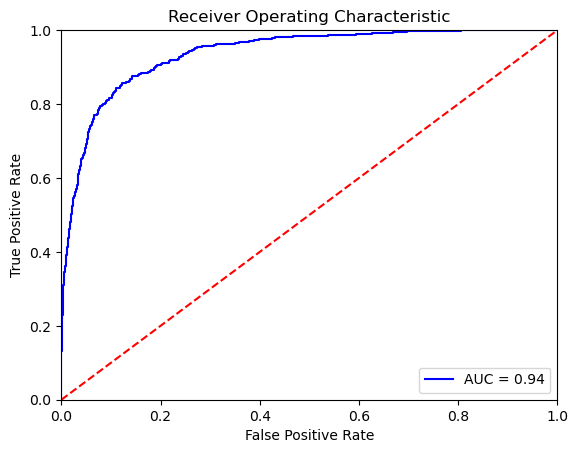

In [56]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 95.52%
------------------------------------------------
Confusion Matrix:
      0    1
0  5644   43
1   228  139
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.76      0.38      0.51       367

    accuracy                           0.96      6054
   macro avg       0.86      0.69      0.74      6054
weighted avg       0.95      0.96      0.95      6054



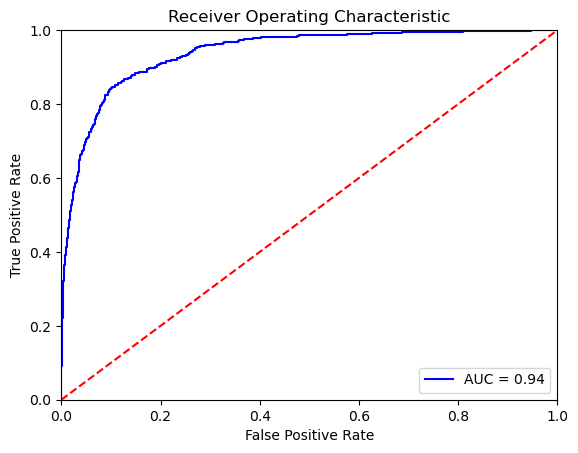

In [57]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 95.34%
------------------------------------------------
Confusion Matrix:
      0    1
0  5631   56
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.72      0.38      0.50       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



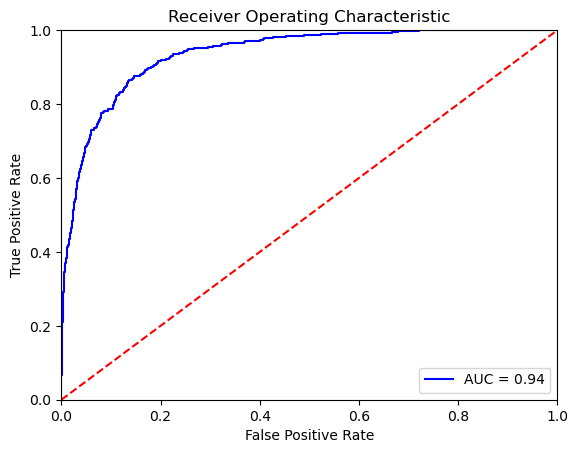

In [58]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:57] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.98%
------------------------------------------------
Confusion Matrix:
      0    1
0  5603   84
1   220  147
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.64      0.40      0.49       367

    accuracy                           0.95      6054
   macro avg       0.80      0.69      0.73      6054
weighted avg       0.94      0.95      0.94      6054



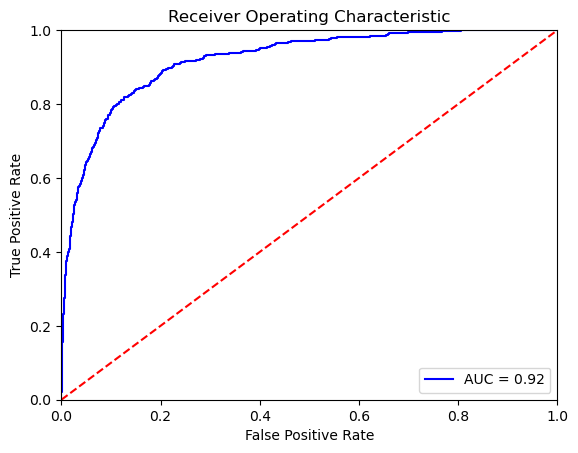

In [59]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.5726330	total: 18.5ms	remaining: 1.83s
1:	learn: 0.4874938	total: 35.3ms	remaining: 1.73s
2:	learn: 0.4102307	total: 52.2ms	remaining: 1.69s
3:	learn: 0.3600151	total: 68.6ms	remaining: 1.65s
4:	learn: 0.3196812	total: 85.4ms	remaining: 1.62s
5:	learn: 0.2906514	total: 102ms	remaining: 1.6s
6:	learn: 0.2666631	total: 119ms	remaining: 1.58s
7:	learn: 0.2459049	total: 135ms	remaining: 1.55s
8:	learn: 0.2285693	total: 151ms	remaining: 1.52s
9:	learn: 0.2174225	total: 167ms	remaining: 1.5s
10:	learn: 0.2102428	total: 183ms	remaining: 1.48s
11:	learn: 0.2013885	total: 199ms	remaining: 1.46s
12:	learn: 0.1961528	total: 215ms	remaining: 1.44s
13:	learn: 0.1917792	total: 232ms	remaining: 1.42s
14:	learn: 0.1871552	total: 248ms	remaining: 1.41s
15:	learn: 0.1822172	total: 265ms	remaining: 1.39s
16:	learn: 0.1780034	total: 280ms	remaining: 1.37s
17:	learn: 0.1756639	total: 297ms	remaining: 1.35s
18:	learn: 0.1727851	total: 315ms	remaining: 1.34s
19:	learn: 0.1709630	total: 332ms	rema

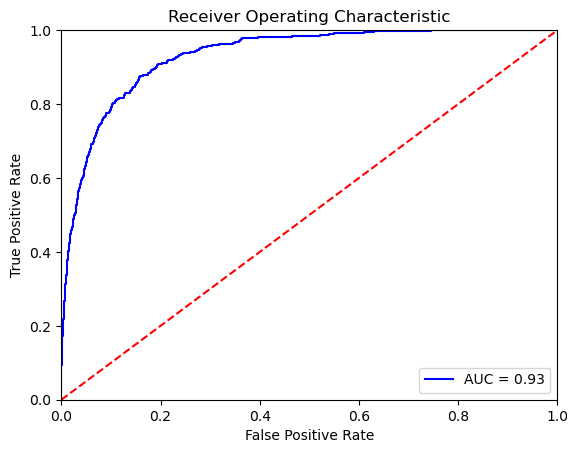

In [60]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 964, number of negative: 13160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14124, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068253 -> initscore=-2.613846
[LightGBM] [Info] Start training from score -2.613846
model accuracy for classification is = 95.39%
------------------------------------------------
Confusion Matrix:
      0    1
0  5634   53
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.73      0.38      0.50       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted a

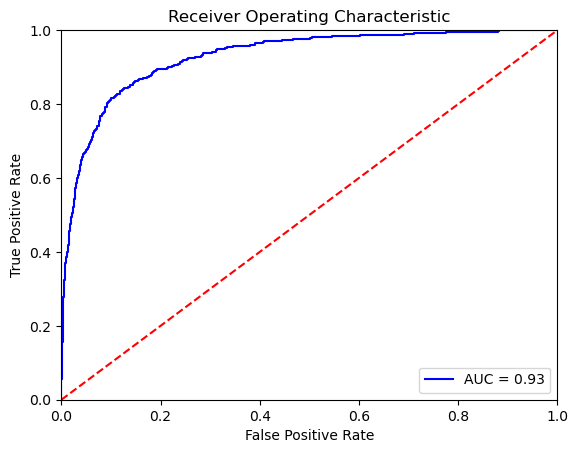

In [61]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.88%
------------------------------------------------
Confusion Matrix:
      0    1
0  5618   69
1   241  126
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.65      0.34      0.45       367

    accuracy                           0.95      6054
   macro avg       0.80      0.67      0.71      6054
weighted avg       0.94      0.95      0.94      6054



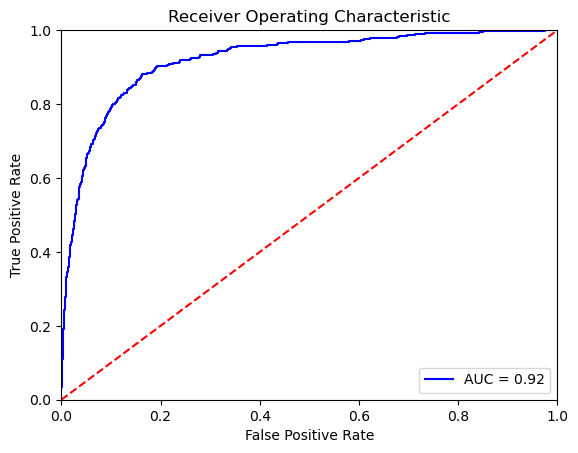

In [62]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [63]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove200d", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

### Model Evaluation

In [64]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
22,StackingClassifier-RF-SVC,untuned,tf,0.999504,0.996885,0.995851,0.996367,0.960522,0.717687,0.574932,0.638427
23,SVC,untuned,tf,0.995044,0.996667,0.930498,0.962446,0.958209,0.735537,0.485014,0.584565
12,RandomForest,untuned,tf,0.999858,1.000000,0.997925,0.998962,0.961348,0.841026,0.446866,0.583630
17,XGBoost,gridsearch,tf,0.965944,0.943119,0.533195,0.681246,0.956227,0.757576,0.408719,0.530973
16,XGBoost,untuned,tf,0.963183,0.960581,0.480290,0.640387,0.956723,0.796610,0.384196,0.518382
4,XGBoost,untuned,w2v,1.000000,1.000000,1.000000,1.000000,0.953254,0.692661,0.411444,0.516239
21,LightGBM,untuned,tf,0.965803,0.947858,0.528008,0.678215,0.954410,0.726368,0.397820,0.514085
19,XGBoost,optuna,tf,0.959714,0.889546,0.467842,0.613188,0.954245,0.727273,0.392371,0.509735
5,XGBoost,gridsearch,w2v,1.000000,1.000000,1.000000,1.000000,0.953750,0.714286,0.395095,0.508772
6,XGBoost,randsearch,w2v,0.999434,1.000000,0.991701,0.995833,0.953089,0.696682,0.400545,0.508651
